# 8. Use external data to better predict the price (Lennert Franssens)

## Introduction

In this task we want to improve the price prediction we made in sprint 1. We reuse the code from then and add a feature that is based on the location of a listing. For that feature we make use of the Foursquare API to find places/venues in the vinicity of a listing.

We first install the needed libraries and import them in the notebook. We also read the listings dataset.

In [297]:
# import sys
# !{sys.executable} -m pip install geopandas
# !{sys.executable} -m pip install mplleaflet
# !{sys.executable} -m pip install bs4
# !{sys.executable} -m pip install geocoder
# !{sys.executable} -m pip install geopy
# !{sys.executable} -m pip install folium
# !{sys.executable} -m pip install lxml
# !{sys.executable} -m pip install pygeoj
# !{sys.executable} -m pip install pyshp
# !{sys.executable} -m pip install datetime
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install --upgrade cython
# !conda install -c conda-forge libspatialindex -y
# !{sys.executable} -m pip install geopandas
# !{sys.executable} -m pip install descartes
# !{sys.executable} -m pip install requests
# !{sys.executable} -m pip install pandana
# !{sys.executable} -m pip install xgboost 
# !{sys.executable} -m pip install osmnet

In [298]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import warnings
import regex as re

# Geographical analysis
import geopandas as gpf #libspatialindex nees to be installed first
import requests

# accessibility analysis
from pandana.loaders import osm
from pandana.loaders import pandash5

# modelling
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


# delete warnings from output
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# figure size in inches
plt.rcParams['figure.figsize'] = 15, 12

# loading the datasets into pandas dataframes
listings = pd.read_csv("data/listings.csv")

## Cleaning the dataset

The cleaning of the dataset is a mix of the sprint 1 and 2 cleaning. We definitely need to shift some rows, drop some unused columns, clean values and transform to numeric data.

In [299]:
shifted_lines = listings[pd.to_numeric(listings["host_verifications"], errors='coerce').notnull()].id
mask = listings['id'].isin(shifted_lines)

# shift lines 1 to the left
listings.loc[mask, 'host_since':'reviews_per_month'] = listings.loc[mask, 'host_since':'reviews_per_month'].shift(-1, axis=1)

In [300]:
listings['priv_bath'] = listings['bathrooms_text']
listings['bathrooms'] = listings['bathrooms_text']

# filter columns
listings = listings[["id", "host_id", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_is_superhost", "host_total_listings_count", 
    "host_verifications", "host_identity_verified", "neighbourhood_cleansed", "latitude", "longitude", "property_type", "room_type",
    "accommodates", "priv_bath", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights","availability_90",
    "number_of_reviews", "number_of_reviews_ltm", "last_review", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication",
    "review_scores_location", "review_scores_value", "instant_bookable", "reviews_per_month"]]

In [301]:
#listings = listings[listings['neighbourhood_cleansed'].notna()]
#listings = listings[listings['price'].notna()]
# clean property types
listings['property_type'] = ['Room'    if re.match('.*room.*', x, re.IGNORECASE) 
                                            else 'House' if re.match('.*house.*', x, re.IGNORECASE) 
                                            else 'Apartment' if re.match('.*apartment.*', x, re.IGNORECASE) 
                                            else 'Other'
                                            for x in listings["property_type"]]

# convert percentage to float
listings["host_response_rate"] = listings['host_response_rate'].str.rstrip('%').astype('float') / 100.0
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0

# convert to number of verification types
listings['host_verifications'] = listings['host_verifications'].apply(eval).apply(lambda x: len(x))

# convert booleans: 1 if true, 0 if false
listings["host_identity_verified"] = listings["host_identity_verified"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)
listings["instant_bookable"] = listings["instant_bookable"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)
listings["host_is_superhost"] = listings["host_is_superhost"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)

# private bathroom and shared bathroom
listings['bathrooms'] = listings['bathrooms'].replace('\s.*', '', regex=True)
listings['bathrooms'] = listings['bathrooms'].replace('^[a-zA-Z].*', '0.5', regex=True)
listings['priv_bath'] = listings['priv_bath'].replace('.*ared.*', '0', regex=True)
listings['priv_bath'] = listings['priv_bath'].replace('.*[a-zA-Z].*', '1', regex=True)

listings['bathrooms'] = listings['bathrooms'].astype(float)
listings['priv_bath'] = listings['priv_bath'].astype(float)

# convert currency to float
listings['price'] = listings['price'].replace('[\$,)]', '', regex=True).astype(float)
listings.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

Now we drop rows where we miss information. These can also be filled up with mean values but that is skipped because we want to focus on the geographic part of the task.

In [302]:
# first we drop the rows that contain missing values
listings.dropna(inplace=True)

# next we convert some columns to numeric values
listings[["accommodates", "bedrooms", "minimum_nights", "number_of_reviews", "review_scores_rating", "longitude", "beds", "host_id", "host_total_listings_count", "maximum_nights", "number_of_reviews_ltm"]] = listings[["accommodates","bedrooms", "minimum_nights", "number_of_reviews", "review_scores_rating", "longitude","beds", "host_id", "host_total_listings_count", "maximum_nights", "number_of_reviews_ltm"]].apply(pd.to_numeric)

In [303]:
# a = pd.get_dummies(listings['host_response_time'], prefix = "hrt")
# b = pd.get_dummies(listings['room_type'], prefix = "rt")
# c = pd.get_dummies(listings['property_type'], prefix = "pt")
# frames = [listings, a, b, c]
# listings = pd.concat(frames, axis = 1)

## Location feature

The locations of the listings are in the neighbourhood of Ghent. That's why we will make a location based feature, extracted from the places/venues that are available in Ghent (city).

First we import a boundary GeoJSON file. We rename the name column to neighbourhood, which is clearer. The unused columns from the dataframe of the GeoJSON file can be dropped.

In [304]:
map_df = gpf.read_file('data/geo/ghent.geojson')
np.sort(map_df.name.unique())
map_df.rename(columns={'name': 'neighbourhood'}, inplace=True)
map_df.drop(['descriptio', 'cartodb_id', 'created_at', 'updated_at'], axis=1, inplace=True)
map_df.head()

,neighbourhood,geometry
0,Dampoort,"MULTIPOLYGON (((3.74075 51.05856, 3.74085 51.0..."
1,Bloemekenswijk,"MULTIPOLYGON (((3.70664 51.07669, 3.70735 51.0..."
2,Rabot - Blaisantvest,"MULTIPOLYGON (((3.72743 51.06812, 3.72755 51.0..."
3,Moscou - Vogelhoek,"MULTIPOLYGON (((3.75658 51.03337, 3.75767 51.0..."
4,Wondelgem,"MULTIPOLYGON (((3.74379 51.11560, 3.74690 51.1..."


Now we have the names of the available neighbourhoods and we also have our listings dataset where each listing corresponds to a neighbourhood. We can create now a dataframe where we store the number of listings and the median price per neigbourhood.

In [305]:
ghent_df = pd.DataFrame(listings.groupby('neighbourhood').size())
ghent_df.rename(columns={0: 'number_of_listings'}, inplace=True)
ghent_df['median_price'] = listings.groupby('neighbourhood').price.median().values

With all the data we have collected already, we can now combine the ghent_df with the map_df dataframes. We do that on the neighbourhood column.

In [306]:
ghent_map_df = map_df.set_index('neighbourhood').join(ghent_df)
ghent_map_df.head()

,geometry,number_of_listings,median_price
neighbourhood,,,
Dampoort,"MULTIPOLYGON (((3.74075 51.05856, 3.74085 51.0...",32.0,54.0
Bloemekenswijk,"MULTIPOLYGON (((3.70664 51.07669, 3.70735 51.0...",10.0,93.5
Rabot - Blaisantvest,"MULTIPOLYGON (((3.72743 51.06812, 3.72755 51.0...",18.0,83.5
Moscou - Vogelhoek,"MULTIPOLYGON (((3.75658 51.03337, 3.75767 51.0...",2.0,46.0
Wondelgem,"MULTIPOLYGON (((3.74379 51.11560, 3.74690 51.1...",9.0,95.0


### Some analysis

We will now do some analysis based on the data in the ghent_map_df dataframe. We can plot the number of listings per neighbourhood (first plot). The plot is based on the GeoJSON data about Ghent. We can also plot the median price of a listing per neighbourhood (second plot). The data in both plots are normalized.

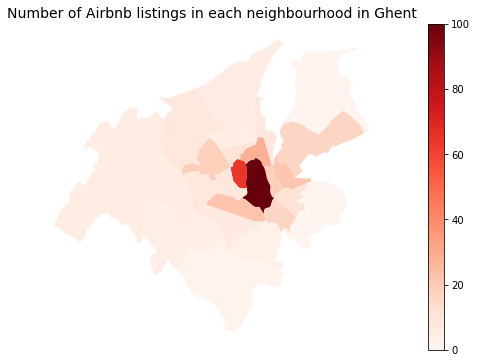

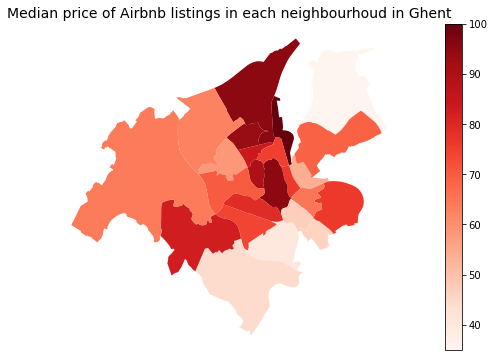

In [307]:
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
ghent_map_df.plot(column='number_of_listings', cmap='Reds', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each neighbourhood in Ghent', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=100))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

fig2, ax2 = plt.subplots(1, figsize=(15, 6))
ghent_map_df.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each neighbourhoud in Ghent', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(ghent_map_df.median_price), vmax=max(ghent_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

We can conclude that the most listings are in the centre of Ghent. The price is high in the city of Ghent, but also some other neighbourhoods have relative high prices.

### Places/venues

We already gained some insights with the data we already had in the given listings dataset. But now we want to make use of an external data source to get more information about the places/venues that are nearby a listing. Therefore we will make use of the Foursquare API.<br><br>
We will create the walkability and ability to reach places as a location feature. The proximity to a place (park, restaurant,...) is used for that feature.

We first define the 'centroid' coordinates of each polygon that describes a neighbourhood. These coordinates are used to find the most popular places/venues of a neighbourhood.

In [308]:
map_df["longitude"] = map_df.centroid.x
map_df["latitude"] = map_df.centroid.y
map_df.head()

,neighbourhood,geometry,longitude,latitude
0,Dampoort,"MULTIPOLYGON (((3.74075 51.05856, 3.74085 51.0...",3.750148,51.052590
1,Bloemekenswijk,"MULTIPOLYGON (((3.70664 51.07669, 3.70735 51.0...",3.707591,51.070787
2,Rabot - Blaisantvest,"MULTIPOLYGON (((3.72743 51.06812, 3.72755 51.0...",3.712477,51.063170
3,Moscou - Vogelhoek,"MULTIPOLYGON (((3.75658 51.03337, 3.75767 51.0...",3.759759,51.025928
4,Wondelgem,"MULTIPOLYGON (((3.74379 51.11560, 3.74690 51.1...",3.714999,51.091413


The following function sends a request to the Foursquare V3 API. We provide the latitude, longitude, radius and some categories to search popular places nearby the given location. The category numbers are part of the API. More information about the API can be found on the following link: https://developer.foursquare.com/reference/place-search.<br><br>
We create a list that stores the venues (gained from the Foursquare API) per neighbourhood.

In [309]:
# Function to loop for places through all neighbourhoods
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v3/places/search?categories=10000,13000,14000,16000,18000&sort=POPULARITY&ll={},{}&radius={}&limit={}'.format(
            lat, 
            lng,
            radius,
            30)

        headers = {
            "Accept": "application/json",
            "Authorization": "fsq3cqB4ezOnNJEURfeUGEsdkG6rMTFrodDz5UwDZV3EWGM="
        }

        response = requests.request("GET", url, headers=headers).json()

        print(response)
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['geocodes']['main']['latitude'], 
            v['geocodes']['main']['longitude'],  
            v['categories'][0]['name']) for v in response.get('results')])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Place', 
                  'Place Latitude', 
                  'Place Longitude', 
                  'Place Category']
    
    return(nearby_venues)

We now call the above function for each neighbourhood that we want to gain more information about. (This code is commented out because it needs to be runned only once. We saved the result 2 cells down.)

In [310]:
# ghent_places = getNearbyVenues(names=map_df['neighbourhood'], latitudes=map_df['latitude'], longitudes=map_df['longitude'], radius = 500)

In [311]:
# Saving Data set
# ghent_places.to_csv('data/geo/ghent_places.csv')

The result from the API calls are stored in a csv file. These can be loaded with the following code.

In [312]:
ghent_places = pd.read_csv('data/geo/ghent_places.csv', index_col=0)

With that list of venues, we can now gain more insights about the venue categories.

In [313]:
print('There are {} unique categories.'.format(len(ghent_places['Place Category'].unique())))

There are 130 unique categories.


In [314]:
ghent_places['Place Category'].unique()

array(['Park', 'Pub', 'Bakery', 'Kebab Restaurant',
       'Historic and Protected Site', 'Sports Club', 'Plaza',
       'Coffee Shop', 'Fast Food Restaurant', 'Dance Studio', 'Bar',
       'Concert Hall', 'Doner Restaurant', 'Bistro', 'Comedy Club',
       'Playground', 'Snack Place', 'Friterie', 'Sports and Recreation',
       'Monument', 'Science Museum', 'Bathing Area', 'Turkish Restaurant',
       'Pizzeria', 'Yoga Studio', 'Gym and Studio', 'Dog Park',
       'Tennis Court', 'Garden', 'Cafeteria', 'Hookah Bar', 'Brasserie',
       'Canal', 'Theater', 'Comfort Food Restaurant', 'Bridge',
       'Landmarks and Outdoors', 'Deli', 'Boxing Gym', 'Asian Restaurant',
       'Sandwich Restaurant', 'Skate Park', 'Arts and Entertainment',
       'Restaurant', 'Equestrian Facility', 'Dining and Drinking',
       'Pool Hall', 'Latin American Restaurant', 'History Museum', 'Farm',
       'Whisky Bar', 'Music Venue', 'Swimming Pool', 'Soccer Field',
       'Bike Trail', 'Gastropub', 'Sushi Res

We have a look at the count per categories that are in our most popular venues list per neighbourhood.

In [315]:
ghent_places.groupby('Place Category').count()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude
Place Category,,,,,,
Amusement Park,1,1,1,1,1,1
Arts and Entertainment,6,6,6,6,6,6
Asian Restaurant,1,1,1,1,1,1
BBQ Joint,3,3,3,3,3,3
Bagel Shop,1,1,1,1,1,1
...,...,...,...,...,...,...
Vegan and Vegetarian Restaurant,5,5,5,5,5,5
Vietnamese Restaurant,2,2,2,2,2,2
Whisky Bar,1,1,1,1,1,1


### Analysis per neighbourhood

We make one-hot encodings of the venues. These will be used when we select the top categories where our feature will be based on.

In [316]:
ghent_onehot = pd.get_dummies(ghent_places[['Place Category']], prefix = "", prefix_sep = "")
ghent_onehot['Neighbourhood'] = ghent_places['Neighbourhood']
fixed_columns = [ghent_onehot.columns[-1]] + list(ghent_onehot.columns[:-1])
ghent_onehot = ghent_onehot[fixed_columns]

ghent_onehot.head()

,Neighbourhood,Amusement Park,Arts and Entertainment,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,...,Theater,Track,Tunnel,Turkish Restaurant,VR Cafe,Vegan and Vegetarian Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio
0,Dampoort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dampoort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dampoort,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dampoort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dampoort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And we can now use the one-hot encodings dataframe to group it by neighbourhood. Then we have a full overview of which categories per neighbourhood are the most popular/top in ranking.

In [317]:
ghent_grouped = ghent_onehot.groupby('Neighbourhood').mean().reset_index()
ghent_grouped

,Neighbourhood,Amusement Park,Arts and Entertainment,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,...,Theater,Track,Tunnel,Turkish Restaurant,VR Cafe,Vegan and Vegetarian Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio
0,Binnenstad,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.333333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bloemekenswijk,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333
2,Brugse Poort - Rooigem,0.000000,0.000000,0.000000,0.033333,0.000000,0.066667,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Dampoort,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.066667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Drongen,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Elisabethbegijnhof - Papegaai,0.000000,0.066667,0.000000,0.066667,0.000000,0.033333,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333
6,Gentbrugge,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Kanaaldorpen en -zone,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Ledeberg,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000
9,Macharius - Heirnis,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.166667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


We can now use the grouped one-hot encodings to write down the top 5 place categories per neighbourhood.

In [318]:
num_top_places = 5

for hood in ghent_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = ghent_grouped[ghent_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['place','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_places))
    print('\n')

----Binnenstad----
                place  freq
0                 Bar  0.33
1              Bakery  0.10
2         Coffee Shop  0.10
3  Italian Restaurant  0.07
4               Plaza  0.07


----Bloemekenswijk----
              place  freq
0            Bakery  0.17
1               Bar  0.10
2             Plaza  0.07
3  Doner Restaurant  0.07
4          Friterie  0.07


----Brugse Poort - Rooigem----
                place  freq
0                Park  0.17
1                 Bar  0.10
2              Bakery  0.07
3  Turkish Restaurant  0.07
4            Friterie  0.07


----Dampoort----
          place  freq
0        Bakery  0.17
1    Playground  0.07
2  Concert Hall  0.07
3         Plaza  0.07
4           Bar  0.07


----Drongen----
                    place  freq
0            Bathing Area  0.25
1                     Bar  0.25
2  Landmarks and Outdoors  0.25
3                  Bridge  0.25
4                   Plaza  0.00


----Elisabethbegijnhof - Papegaai----
                  place  freq


The following 2 cells generate a dataframe from the previous result.

In [319]:
# Function to sort places in descending order
def return_most_common_places(row, num_top_places):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_places]

In [320]:
import numpy as np

# New dataframe ordered
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_places):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = ghent_grouped['Neighbourhood']

for ind in np.arange(ghent_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_places(ghent_grouped.iloc[ind, :], 
                                                                          num_top_places)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Binnenstad,Bar,Bakery,Coffee Shop,Italian Restaurant,Plaza
1,Bloemekenswijk,Bakery,Bar,Plaza,Doner Restaurant,Friterie
2,Brugse Poort - Rooigem,Park,Bar,Bakery,Turkish Restaurant,Friterie
3,Dampoort,Bakery,Playground,Concert Hall,Plaza,Bar
4,Drongen,Bathing Area,Bar,Landmarks and Outdoors,Bridge,Plaza


### Category selection

We can now have a look at which categories we will use in our calculation of how near a venue is. These categories must be popular in most of the neighbourhoods.

In [321]:
neighbourhoods_venues_sorted.groupby('1st Most Common Venue').count()

,Neighbourhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1st Most Common Venue,,,,,
Bakery,5,5,5,5,5
Bar,6,6,6,6,6
Bathing Area,1,1,1,1,1
Cafeteria,1,1,1,1,1
Harbor / Marina,1,1,1,1,1
Park,4,4,4,4,4
Playground,1,1,1,1,1
Plaza,1,1,1,1,1
Pub,1,1,1,1,1


The most common venues are Park, Bakery and Bar.

## Walkability to nearest venue

With the most popular and common venue categories known, we can now define the walkability to the nearest venues of a listing. We will use the Park category to work with.

In [322]:
#Get just Pub, Cafe, Bar And Restaurant

# Points of interest already exists. Load from ghent_places
df_pois = ghent_places.copy()
#terms = ['Bar', 'Pub', 'Restaurant', 'Café', 'Bakery', 'Park', 'Bridge', 'Plaza', 'Friterie']
#terms = ['Park','Plaza']
terms = ['Park']
df_pois = df_pois[df_pois['Place Category'].str.contains('|'.join(terms))]
df_pois.to_csv('data/geo/foursquare_amenities.csv', index=id, header=True)

df_pois.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category
0,Dampoort,51.052590,3.750148,Bijgaardepark,51.050959,3.743387,Park
20,Dampoort,51.052590,3.750148,Banierpark,51.053710,3.745673,Park
37,Bloemekenswijk,51.070787,3.707591,Bloemekenspark,51.067790,3.710096,Park
51,Bloemekenswijk,51.070787,3.707591,Losloopweide,51.069324,3.711180,Dog Park
63,Rabot - Blaisantvest,51.063170,3.712477,Rabotpark,51.063817,3.716470,Park


Next, we put all relatives of a category together under the same category name. This is a sort of cleaning the data.

In [323]:
df_pois.loc[df_pois['Place Category'].str.contains('Restaurant', case=False), 'Place Category'] = 'Restaurant'
df_pois.loc[df_pois['Place Category'].str.contains('Bar', case=False), 'Place Category'] = 'Bar'
df_pois.loc[df_pois['Place Category'].str.contains('Pub', case=False), 'Place Category'] = 'Pub'
df_pois.loc[df_pois['Place Category'].str.contains('Bakery', case=False), 'Place Category'] = 'Bakery'
df_pois.loc[df_pois['Place Category'].str.contains('Park', case=False), 'Place Category'] = 'Park'
df_pois.loc[df_pois['Place Category'].str.contains('Bridge', case=False), 'Place Category'] = 'Bridge'
df_pois.loc[df_pois['Place Category'].str.contains('Plaza', case=False), 'Place Category'] = 'Plaza'
df_pois.loc[df_pois['Place Category'].str.contains('Friterie', case=False), 'Place Category'] = 'Friterie'

df_pois['Place Category'].value_counts()

Park    68
Name: Place Category, dtype: int64

We will make use of the OSM API to get street network data. Therefore we first need to define the bounding box of Ghent (4 coordinates).

In [324]:
bbox = (3.579762,50.979639,3.849325,51.187946)

With that bounding box, we can query the API to find the street networking withing the given bounding box.

In [325]:
network = osm.pdna_network_from_bbox(bbox=bbox)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](50.97963900,3.57976200,51.18794600,3.84932500);>;);out;'}"
Downloaded 22,295.8KB from www.overpass-api.de in 4.51 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 4.84 seconds
Returning OSM data with 155,169 nodes and 32,107 ways...
Edge node pairs completed. Took 20.05 seconds
Returning processed graph with 38,101 nodes and 52,970 edges...
Completed OSM data download and Pandana node and edge table creation in 26.51 seconds
Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 38101
Setting CH edge vector of size 53578
Range graph removed 2810 edges of 107156
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% .

We now store the nodes that are connected to fewer than some threshold of other nothes withing a given distance. After that we remove some lowe-connectivity nodes (lcn, calculated in the cell) and save the network onto our drive.

In [326]:
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

network.save_hdf5('data/geo/mynetwork.h5',rm_nodes=lcn)

### Calculate the walkability to a venue

We will now search for the 10 nearest popular venues of a listing. The search is bounded to a distance of 3 km.

In [327]:
distance = 3000
num_pois = 10
num_categories = len(df_pois['Place']) + 1

We will let the street network model (data gained from OSM API) precompute range queries. This will improve the speed because the model can use cached values. We also need to init the C++ engine from our chosen model.

In [328]:
network.precompute(distance + 1)
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)
network.set_pois(category='all', x_col = df_pois['Place Longitude'], y_col = df_pois['Place Latitude'])

Reading parameters from init_pois()
Reading parameters from init_pois()


The model can search now for the nearest venues of each node in our street network. The return value is a dataframe where each cell represents the network distance from the node to each of the nearest venues of each node. The distance is in meters.

In [329]:
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)
all_access.head()

,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
145715,1565.907959,1671.979980,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
145718,1159.344971,2058.305908,2378.381104,2388.412109,2450.528076,2450.528076,2584.882080,3000.000000,3000.000000,3000.000000
145758,183.182999,884.395020,1183.447021,1214.854980,1241.224976,1272.090942,1430.374023,1444.271973,1535.104004,1624.262939
145761,484.263000,556.270996,1169.191040,1395.677002,1531.151978,1559.415039,1616.651001,1794.076050,1807.973999,1841.152954
145763,529.357971,890.690002,1045.088013,1509.442017,1509.442017,1511.979980,1544.394043,1862.812012,1893.833984,1943.135986


### Plot accessibility maps

We now store our bounding box as a list (instead of a tuple) to pass it through the plot function of our model. We also store some other values that are used to plot the maps.

In [330]:
bbox = [3.579762,50.979639,3.849325,51.187946]

bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])

fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'Reds', 
               'edgecolor':'none'}
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'Reds', 
                   'edgecolor':'none'}
cbar_kwargs = {}
bmap_kwargs = {}

agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'Reds'

bgcolor = 'k'

We first plot the distance to the nearest venue. That venue can be of any type. We see that the further from the center, the further venues are located for nodes on the street network.

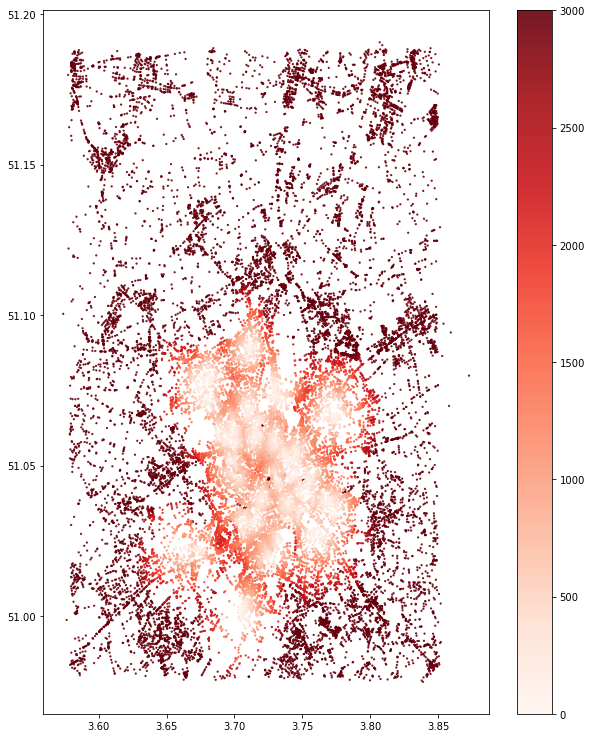

In [331]:
n = 1
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                            cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
fig.savefig('data/geo/accessibility-ghent.png', dpi=200, bbox_inches='tight')

The 2 next plots are:
* The distance to the fifth nearest venue. We see that the surface of nodes on the street network is shrunk. That is a normal tendency.
* The distance to the fifth nearest venue on a hexbin plot. The results are the same from the previous plot.


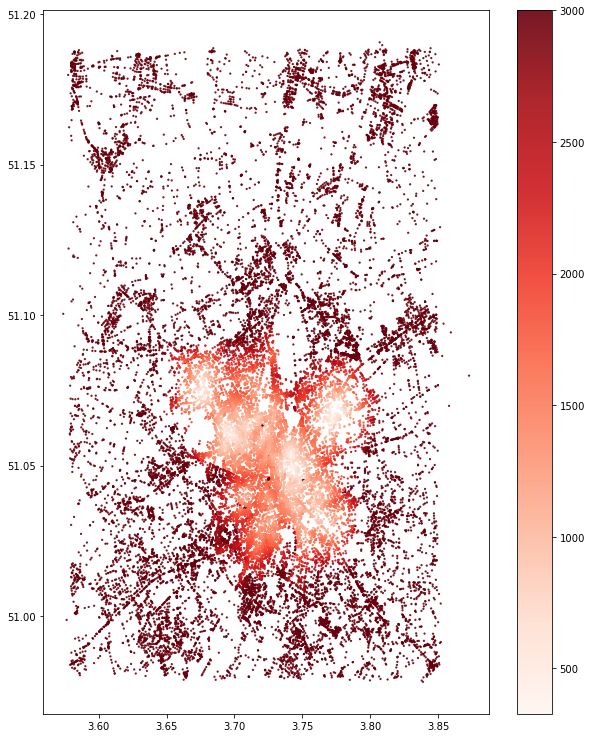

In [332]:
n = 5
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
fig.savefig('data/geo/accessibility-nearest5th-ghent.png', dpi=200, bbox_inches='tight')

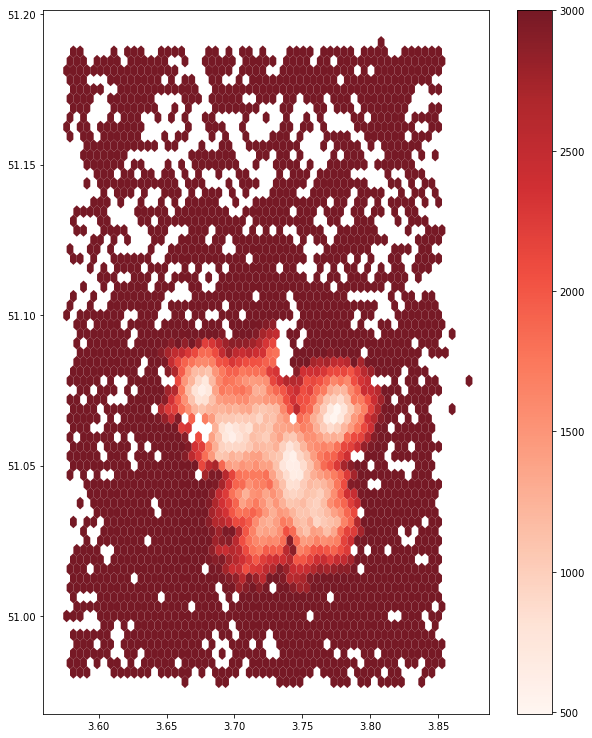

In [333]:
fig, ax = network.plot(all_access[n], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
fig.savefig('data/geo/accessibility-hexbins-ghent.png', dpi=200, bbox_inches='tight')

We will use the distance to the fifth nearest venue as a compound measure of accessibility. This is calculated with the street network model.

In [334]:
num_pois = 5
N_nearest_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

print('{:,} nodes'.format(len(N_nearest_access)))

Access_Score = pd.DataFrame(N_nearest_access[5])
Access = Access_Score.rename(columns={5:'Score'})
Access.head()

38,101 nodes


,Score
id,
145715,3000.000000
145718,2450.528076
145758,1241.224976
145761,1531.151978
145763,1509.442017


We now generate an overview of our df_pois dataset. We see that we use the column name node_ids. That name must be used on our Access_Score dataframe to be able to merge that dataframe with the df_pois dataframe.

In [335]:
df_pois['node_ids'] = network.get_node_ids(df_pois['Place Longitude'], df_pois['Place Latitude'])
df_pois.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category,node_ids
0,Dampoort,51.052590,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735
20,Dampoort,51.052590,3.750148,Banierpark,51.053710,3.745673,Park,8729747899
37,Bloemekenswijk,51.070787,3.707591,Bloemekenspark,51.067790,3.710096,Park,7479652411
51,Bloemekenswijk,51.070787,3.707591,Losloopweide,51.069324,3.711180,Park,7479652418
63,Rabot - Blaisantvest,51.063170,3.712477,Rabotpark,51.063817,3.716470,Park,3010231245


In [336]:
Access.reset_index(level=0, inplace=True)
Access = Access.rename(columns={'id':'node_ids'})
merged = pd.merge(df_pois, Access, on='node_ids')

We also rename the neighbourhood column of our listings dataframe to be able to merge that dataframe with the merged df_pois and Access dataframe.

In [337]:
listings.rename(columns={'neighbourhood': 'Neighbourhood'}, inplace=True)
listings_merged = pd.merge(merged, listings, on='Neighbourhood')
listings_merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category,node_ids,Score,id,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,684.840027,9087777,...,2020-10-13,4.64,4.85,4.77,4.88,4.90,4.48,4.69,1,7.32
1,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,684.840027,10083084,...,2020-09-25,4.54,4.76,4.71,4.81,4.83,4.37,4.62,1,8.41
2,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,684.840027,11454300,...,2021-07-04,4.43,4.23,4.43,4.43,4.36,4.14,4.57,1,0.24
3,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,684.840027,12423613,...,2019-09-06,4.80,4.92,4.92,4.94,4.93,4.58,4.78,1,3.49
4,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,684.840027,14541839,...,2019-10-01,4.78,4.81,4.90,4.88,4.79,4.48,4.80,0,2.96


We now save the last merged dataframe to our local storage. This dataframe will be used to predict the prices of the listings.

In [338]:
listings_merged.to_csv('data/listings_model_with_geo.csv', index=id, header=True)

## Predict the prices

In this last section, we predict the prices. But we first load and open the merged dataset.

In [339]:
df_merged = pd.read_csv('data/listings_model_with_geo.csv', index_col=0)
df_merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category,node_ids,Score,id,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,684.840027,9087777,...,2020-10-13,4.64,4.85,4.77,4.88,4.90,4.48,4.69,1,7.32
1,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,684.840027,10083084,...,2020-09-25,4.54,4.76,4.71,4.81,4.83,4.37,4.62,1,8.41
2,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,684.840027,11454300,...,2021-07-04,4.43,4.23,4.43,4.43,4.36,4.14,4.57,1,0.24
3,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,684.840027,12423613,...,2019-09-06,4.80,4.92,4.92,4.94,4.93,4.58,4.78,1,3.49
4,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,684.840027,14541839,...,2019-10-01,4.78,4.81,4.90,4.88,4.79,4.48,4.80,0,2.96


We can now drop features that are no longer needed. (This is copied from our notebook from sprint 1, the analysis to define which features are less important can be found there.)

In [340]:
df_merged.drop(['Neighbourhood Longitude', 'Place Latitude', 'Place Longitude','Neighbourhood Latitude',
               'Place Category', 'node_ids', 'Place'], axis=1, inplace=True)

We transform the features that benifit from a log transformation. These features will be normally distributed after the transformation.

In [341]:
tfo_listings = df_merged[["id", "Score", "host_total_listings_count", "accommodates", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights", "number_of_reviews"]]

for col in ["Score", "host_total_listings_count", "accommodates", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights", "number_of_reviews"]:
    tfo_listings[col] = tfo_listings[col].astype('float64').replace(0.0, 0.01)
    tfo_listings[col] = np.log(tfo_listings[col])

The predictive features X and the target feature y can be separated. X will be scaled.

In [342]:
X = tfo_listings.drop('price', axis=1)
y = tfo_listings.price

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

We can split the dataset into train and test sets to train and test our model.

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 

We first use the Spatial Hedonic Price Model. This model involves regressing observed asking-prices for the listings against the attributes of a property. We add the location feature also and will see if this has an impact on the price modelling.

In [344]:
hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train)

training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))


Training RMSE: 0.1511
Validation RMSE: 0.1653

Training r2: 0.5328
Validation r2: 0.5152


We have around 56% of variance in the target (price) variable. We will compare the actual prices with the predicted prices now.

In [345]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

,Actual,Predicted
0,3.806662,4.545586
1,4.499810,4.653184
2,5.572154,4.837407
3,5.164786,4.774812
4,4.867534,4.468346
...,...,...
260,3.931826,3.736763
261,4.382027,4.198199
262,4.248495,4.003397
263,4.905275,4.733332


And these values can now be used on a scatter plot to visualise the result.

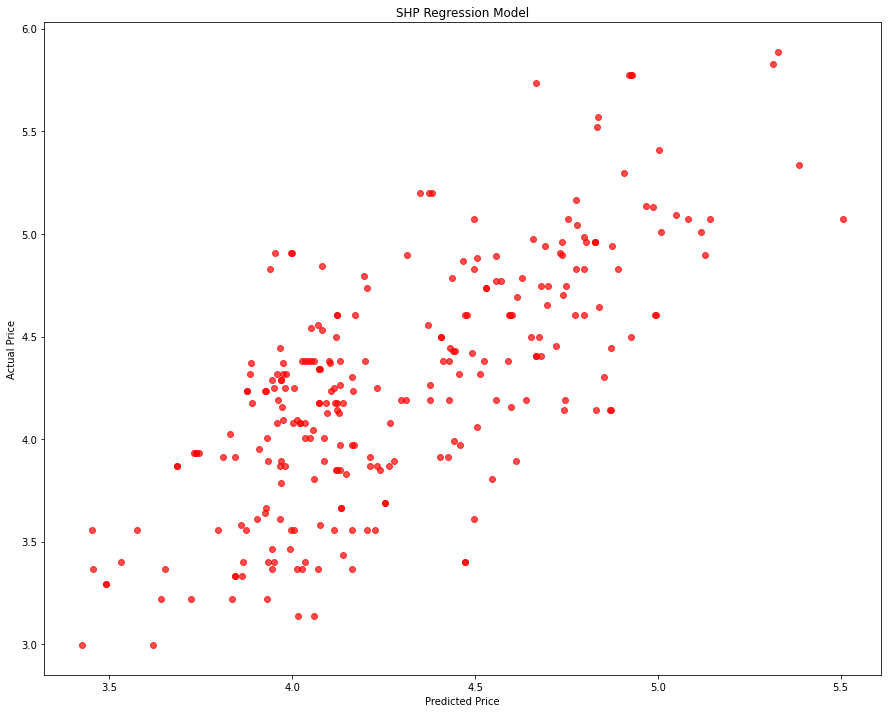

In [346]:
actual_values = y_test
plt.scatter(val_preds_hpm_reg, actual_values, alpha=.7,
            color='r')
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_hpm_reg))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()

The result is good, but not perfect yet. We try another model to see if that model is better. We will use the extreme gradient boosting model. That model is an implementation of gradient boosted decision trees. These are designed for speed and performance.

In [347]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Training MSE: 0.0004
Validation MSE: 0.0243

Training r2: 0.9988
Validation r2: 0.9288


And we see that our results are very good now. The following code cells provide us more information about the predicted versus the actual price and plot that in a scatterplot.

In [348]:
y_test_array = np.array(list(y_test))
val_preds_xgb_reg_array = np.array(val_preds_xgb_reg)
xgb_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_xgb_reg_array.flatten()})
xgb_df

,Actual,Predicted
0,3.806662,3.867128
1,4.499810,4.754093
2,5.572154,5.164613
3,5.164786,5.139365
4,4.867534,4.788204
...,...,...
260,3.931826,3.934678
261,4.382027,4.330647
262,4.248495,4.283987
263,4.905275,5.010759


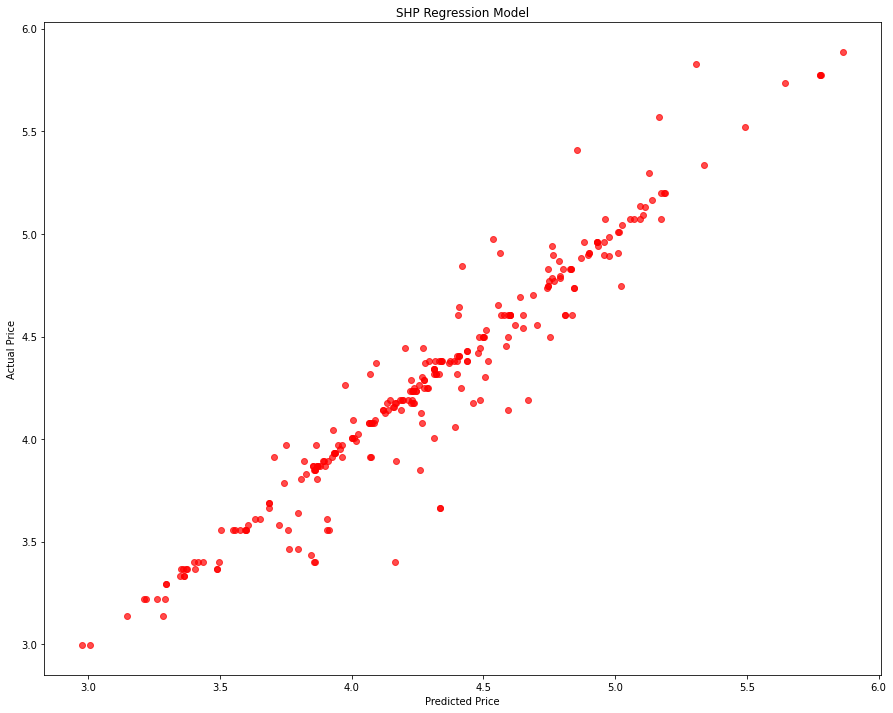

In [349]:
actual_values = y_test
plt.scatter(val_preds_xgb_reg, actual_values, alpha=.7,
            color='r')
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_xgb_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_xgb_reg))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()

Last we want to see how our Score feature (location based feature) performs. It has a relative low impact on the prediction of the price. This can be due to several reasons. But it was very instructive to work with this kind of data and try to use it as an external feature for an existing dataset with existing static data.

In [350]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

,weight
bedrooms,0.395271
accommodates,0.371798
bathrooms,0.046628
beds,0.041260
number_of_reviews,0.028293
host_total_listings_count,0.027947
minimum_nights,0.027583
maximum_nights,0.025677
id,0.020028
Score,0.015515


References for this task:
* https://www.kaggle.com/matevaradi/nyc-airbnb-geospatial-analysis-price-predictions/notebook
* https://github.com/gracecarrillo/Predicting-Airbnb-prices-with-machine-learning-and-location-data/blob/gh-pages/Exploring_Edinburgh_Graciela_Carrillo.ipynb